### Initialize

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from adjustText import adjust_text
from scipy.sparse import coo_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader

import pygini

random.seed(42)
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [2]:
chr_index = pd.read_csv("index.csv", header=0)
pos_coord_egfr = np.where(chr_index["loc"] == "chr7_55000000")[0][0]
pos_coord_myc = np.where(chr_index["loc"] == "chr8_127000000")[0][0]

window_0 = 5
window_1 = 5


chr_size = [249, 243, 199, 191, 182, 171, 160, 146, 139, 134, 136, 134, 115, 108, 102, 91, 84, 81, 59, 65, 47, 51, 157]

In [3]:
def read_mtx(path, index):
    contact_mat = pd.read_csv(path, sep="\t", header=0)
    contact_mat = contact_mat[(contact_mat["chrom1"] != "chrY") & (contact_mat["chrom2"] != "chrY")]
    contact_mat = pd.concat([contact_mat["chrom1"] + "_" + contact_mat["start1"].astype(str),
                             contact_mat["chrom2"] + "_" + contact_mat["start2"].astype(str), contact_mat["count"]],
                            axis=1)
    contact_mat.columns = ["loc1", "loc2", "count"]
    contact_mat = pd.merge(contact_mat, index, left_on="loc1", right_on="loc", how="left").drop(["loc", "loc1"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index1"})
    contact_mat = pd.merge(contact_mat, index, left_on="loc2", right_on="loc", how="left").drop(["loc", "loc2"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index2"})
    contact_mat = coo_matrix((contact_mat['count'], (contact_mat['index1'], contact_mat['index2'])),
                             shape=(index.shape[0], index.shape[0]))
    contact_mat = contact_mat.toarray()

    return contact_mat

In [4]:
def prep_data(sample, coord, index, is_pos, win0):
    matrices_f2 = []
    bcs = []

    directories = sorted(
        [d for d in os.listdir("data/raw/" + sample) if os.path.isdir(os.path.join("data/raw/" + sample, d))])
    for directory in directories:

        if not os.path.exists("data/raw/" + sample + "/" + directory + "/1000000.CNV.bedGraph"):
            continue

        try:
            mtx = read_mtx("data/raw/" + sample + "/" + directory + "/matrix.mtx", index)
        except:
            continue

        mtx_f2 = mtx[(coord - int((win0 + 1) / 2) + 1):(coord + int((win0 + 1) / 2)), :]

        stacked_mtx_f2 = torch.from_numpy(mtx_f2).to_sparse_coo()

        matrices_f2.append(stacked_mtx_f2)
        bcs = bcs + [directory]

    input = torch.stack(matrices_f2, dim=0)

    if is_pos:
        label = torch.from_numpy(np.ones(input.shape[0])).int()
    else:
        label = torch.from_numpy(np.zeros(input.shape[0])).int()

    return input, label, bcs

### Prepare data

In [5]:
orig_index = pd.read_csv("data/raw/LC675/LC675_TTTGGTTGTTGGCGAA/1000000.CNV.bedGraph", sep="\t", header=None).iloc[:,
             0:3]

orig_index.columns = ["chrom", "start", "end"]
orig_index = orig_index[orig_index["chrom"] != "chrY"]
orig_index = orig_index["chrom"] + "_" + orig_index["start"].astype(str)
orig_index = pd.concat([orig_index, pd.DataFrame(np.arange(orig_index.shape[0]))], axis=1)
orig_index.columns = ["loc", "index"]

orig_index.to_csv("index.csv", index=False)

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC499", pos_coord_egfr, chr_index, True, window_0)
neg_data, neg_label, neg_bcs = prep_data("LC500", pos_coord_egfr, chr_index, False, window_0)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_499500.npy")
torch.save(label, "data/processed/label_499500.npy")
torch.save(barcode, "data/processed/barcodes_499500.npy")


In [ ]:
val_split = 0.1

len_indices = len(input_all)
all_indices = list(range(len_indices))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indices))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_train = torch.index_select(input_all, 0, train_indices)
label_train = torch.index_select(label, 0, train_indices)
bcs_train = [barcode[i] for i in train_indices]

input_val = torch.index_select(input_all, 0, val_indices)
label_val = torch.index_select(label, 0, val_indices)
bcs_val = [barcode[i] for i in val_indices]

pd.DataFrame(bcs_val).to_csv("data/processed/barcode_val_499500.txt", index=False, header=False)

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC729", pos_coord_myc, chr_index, True, window_0)
neg_data, neg_label, neg_bcs = prep_data("LC730", pos_coord_myc, chr_index, False, window_0)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_729730.npy")
torch.save(label, "data/processed/label_729730.npy")
torch.save(barcode, "data/processed/barcode_729730.npy")

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC676", pos_coord_myc, chr_index, True, window_0)
neg_data, neg_label, neg_bcs = prep_data("LC677", pos_coord_myc, chr_index, False, window_0)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_676677.npy")
torch.save(label, "data/processed/label_676677.npy")
torch.save(barcode, "data/processed/barcode_676677.npy")

In [ ]:
val_split = 0.1

len_indices = len(input_all)
all_indices = list(range(len_indices))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indices))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_train = torch.index_select(input_all, 0, train_indices)
label_train = torch.index_select(label, 0, train_indices)
bcs_train = [barcode[i] for i in train_indices]

input_val = torch.index_select(input_all, 0, val_indices)
label_val = torch.index_select(label, 0, val_indices)
bcs_val = [barcode[i] for i in val_indices]

pd.DataFrame(bcs_val).to_csv("data/processed/barcode_val_676677.txt", index=False, header=False)

### Define model

In [5]:
input_499500 = torch.load("data/processed/input_499500.npy").to_dense()
label_499500 = torch.load("data/processed/label_499500.npy")
barcode_499500 = torch.load("data/processed/barcode_499500.npy")

input_676677 = torch.load("data/processed/input_676677.npy").to_dense()
label_676677 = torch.load("data/processed/label_676677.npy")
barcode_676677 = torch.load("data/processed/barcode_676677.npy")

input_729730 = torch.load("data/processed/input_729730.npy").to_dense()
label_729730 = torch.load("data/processed/label_729730.npy")
barcode_729730 = torch.load("data/processed/barcode_729730.npy")

In [6]:
coordinate_499500 = np.repeat(pos_coord_egfr, input_499500.shape[0]).tolist()
coordinate_676677 = np.repeat(pos_coord_myc, input_676677.shape[0]).tolist()
coordinate_729730 = np.repeat(pos_coord_myc, input_729730.shape[0]).tolist()

In [7]:
input_all = input_499500
label = label_499500
barcode = barcode_499500  # + barcode_676677
coordinate = coordinate_499500  # + coordinate_676677

#input_all = torch.cat((input_499500, input_676677), dim=0)
#label = torch.cat((label_499500, label_676677), dim=0)

In [8]:
validation_bcs_499500 = pd.read_table("data/processed/barcode_val_499500.txt", header=None).iloc[:, 0].tolist()
#validation_bcs_676677 = pd.read_table("data/processed/barcode_val_676677.txt",header=None).iloc[:,0].tolist()
validation_bcs = validation_bcs_499500  # + validation_bcs_676677

validation_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] in validation_bcs])
training_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] not in validation_bcs])

In [9]:
input_train = torch.index_select(input_all, 0, training_indices)
label_train = torch.index_select(label, 0, training_indices)
barcode_train = [barcode[i] for i in training_indices]
coordinate_train = [coordinate[i] for i in training_indices]

input_val = torch.index_select(input_all, 0, validation_indices)
label_val = torch.index_select(label, 0, validation_indices)
barcode_val = [barcode[i] for i in validation_indices]
coordinate_val = [coordinate[i] for i in validation_indices]

In [10]:
class QuadDataset(Dataset):
    def __init__(self, input, label, barcode, coord):
        self.input = input
        self.label = label
        self.barcode = barcode
        self.coord = coord

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_s = self.input[index]
        label_s = self.label[index]
        bc_s = self.barcode[index]
        coord_s = self.coord[index]

        return input_s, label_s, bc_s, coord_s

In [11]:
batch_size = 32

train_dataloader = DataLoader(QuadDataset(input_train, label_train, barcode_train, coordinate_train),
                              batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(QuadDataset(input_val, label_val, barcode_val, coordinate_val), batch_size=batch_size,
                            shuffle=False)
test_dataloader1 = DataLoader(QuadDataset(input_676677, label_676677, barcode_676677, coordinate_676677),
                              batch_size=batch_size, shuffle=False)
test_dataloader2 = DataLoader(QuadDataset(input_729730, label_729730, barcode_729730, coordinate_729730),
                              batch_size=batch_size, shuffle=False)

In [12]:
def zi_pois_noise(shape, lambda_, p_zero):
    uniform_noise = torch.rand(shape)

    zero_mask = uniform_noise < p_zero

    poisson_noise = torch.poisson(lambda_ * torch.ones(shape))

    noise = poisson_noise * ~zero_mask

    return noise

In [13]:
class BootBCELoss(nn.Module):
    def __init__(self, alpha, bootstrap_type, pos_weight):
        super(BootBCELoss, self).__init__()
        self.alpha = alpha
        self.bootstrap_type = bootstrap_type
        self.pos_weight = pos_weight

    def forward(self, prediction_tensor, target_tensor):
        if self.bootstrap_type == 'soft':
            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * torch.sigmoid(prediction_tensor)
        elif self.bootstrap_type == 'hard':
            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * (
                        torch.sigmoid(prediction_tensor) > 0.5).float()
        else:
            raise ValueError('Not a valid value of bootstrap_type')

        per_entry_cross_ent = F.binary_cross_entropy_with_logits(input=prediction_tensor,
                                                                 target=bootstrap_target_tensor, reduction='mean',
                                                                 pos_weight=torch.Tensor([self.pos_weight]).to("mps"))

        return per_entry_cross_ent

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_f2_l1 = nn.Conv2d(1, 8, kernel_size=(5, 45), stride=(1, 11), padding=(0, 2))
        self.conv_f2_l2 = nn.Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4), padding=(0, 0))

        self.bn_f2_l1 = nn.BatchNorm2d(8)
        self.bn_f2_l2 = nn.BatchNorm2d(16)

        self.bn_fc_l1 = nn.BatchNorm1d(64)

        self.pool_f2_l1 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)
        self.pool_f2_l2 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)

        self.fc_l1 = nn.Linear(5 * 5 + 12 * 16 + 5 + 1, 64)
        self.fc_l2 = nn.Linear(64, 1)

        #self.dropout_f1 = nn.Dropout(0.5)
        self.dropout_f2 = nn.Dropout(0.5)

        self.dropout_fc = nn.Dropout(0.5)

    def forward(self, x2, coord):
        #if self.training:
        #    noise = zi_pois_noise(x2.shape, 1, 0.9999)  # test this
        #    x2 = x2 + noise.float().to("mps")

        start_indices = coord - int((5 + 1) / 2) + 1
        end_indices = coord + int((5 + 1) / 2)
        
        x2_chr = torch.split(x2[...,2,:], chr_size, dim=-1)
        x2_c = torch.stack([torch.squeeze(torch.sum(st, dim=-1), dim=-1) / st.shape[-1] for st in x2_chr], dim=-1)
        
        #chr = F.normalize(x2_c, dim=-1, p=1)
        
        gini = []
        for i in range(x2_c.shape[0]):
            gini.append(torch.tensor(pygini.gini(x2_c[i, :].cpu().numpy()),dtype=torch.float32))
        gini = torch.unsqueeze(torch.stack(gini, dim=0).to("mps"), dim=-1)
        
        d4_slices = []

        for i in range(x2.size(0)):
            d4_slices.append(x2[i, ..., start_indices[i]:end_indices[i]])

        x1 = torch.stack(d4_slices, dim=0)

        x1 = torch.log2(x1 + 1)
        x2 = (x2 > 0).float()

        x2_s = F.normalize(torch.squeeze(torch.sum(x2, dim=-1), dim=1), dim=-1, p=1)

        x2 = self.pool_f2_l1(F.relu(self.bn_f2_l1(self.conv_f2_l1(x2))))
        x2 = self.dropout_f2(x2)
        x2 = self.pool_f2_l2(F.relu(self.bn_f2_l2(self.conv_f2_l2(x2))))

        x1 = x1.view(-1, 5 * 5)
        x2 = x2.view(-1, 12 * 16)

        #x = torch.cat((torch.zeros_like(x1), x2, x2_s, gini), dim=1)
        #x = torch.cat((x1, torch.zeros_like(x2), x2_s, gini), dim=1)
        #x = torch.cat((x1, x2, torch.zeros_like(x2_s), gini), dim=1)
        #x = torch.cat((x1, x2, x2_s, torch.zeros_like(gini)), dim=1)
        
        x = torch.cat((x1, x2, x2_s, gini), dim=1)

        x = self.dropout_fc(F.gelu(self.bn_fc_l1(self.fc_l1(x))))

        x = self.fc_l2(x)

        return x.squeeze(-1)

In [15]:
model = CNN().to("mps")

prob_threshold = 0.5

In [16]:
criterion = BootBCELoss(alpha=0.8, bootstrap_type="hard", pos_weight=0.06).to("mps")

optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor=0.1)

train_losses_epoch = []
val_losses_epoch = []

accuracies_epoch = []
precision_epoch = []
sensitivity_epoch = []
specificity_epoch = []
f1_epoch = []

epochs = []

num_epochs = 100

### Train model

In [ ]:
for epoch in range(num_epochs):

    if epoch >= 60:
        scheduler.step()

    losses = []
    sizes = []

    model.train()
    for x2, y0, _, coord in train_dataloader:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")

        optimizer.zero_grad()
        yh = model(x2, coord)

        loss = criterion(yh, y0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        sizes.append(len(y0))

    train_loss = np.average(losses, weights=sizes)

    losses = []
    sizes = []

    val_labels = []
    val_predictions = []
    val_scores = []
    val_directories = []

    model.eval()
    with torch.no_grad():
        for x2, y0, bcs, coord in val_dataloader:
            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, coord)

            loss = criterion(yh, y0)

            yp = (torch.sigmoid(yh) > prob_threshold).int()

            accu = torch.sum((yp == y0).float()) / len(y0)

            losses.append(loss.item())
            sizes.append(len(y0))

            val_labels = val_labels + y0.int().to("cpu").numpy().tolist()
            val_predictions = val_predictions + yp.to("cpu").numpy().tolist()
            val_scores = val_scores + torch.sigmoid(yh).to("cpu").numpy().tolist()
            val_directories = val_directories + list(bcs)

        pred_summary = pd.DataFrame(
            {"label": val_labels, "prediction": val_predictions, "score": val_scores, "barcode": val_directories})
        pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

        conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
        tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

        accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
        precision = precision_score(pred_summary["label"], pred_summary["prediction"])
        recall = recall_score(pred_summary["label"], pred_summary["prediction"])
        f1 = f1_score(pred_summary["label"], pred_summary["prediction"])
        specificity = tn / (tn + fp)

        val_loss = np.average(losses, weights=sizes)

    train_losses_epoch.append(train_loss)
    val_losses_epoch.append(val_loss)
    accuracies_epoch.append(accuracy)
    precision_epoch.append(precision)
    sensitivity_epoch.append(recall)
    specificity_epoch.append(specificity)
    f1_epoch.append(f1)

    epochs.append(epoch + 1)

    print(
        f'epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_accu: {accuracy:.4f}, val_prec: {precision:.4f}, val_sens: {recall:.4f}, val_spec: {specificity:.4f}, val_f1: {f1:.4f}')

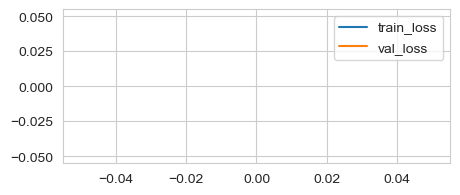

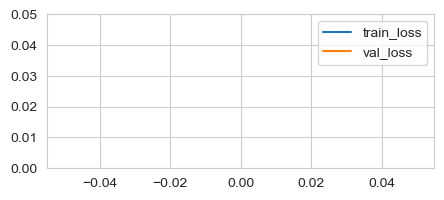

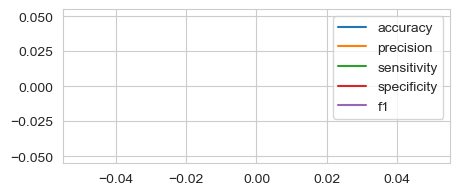

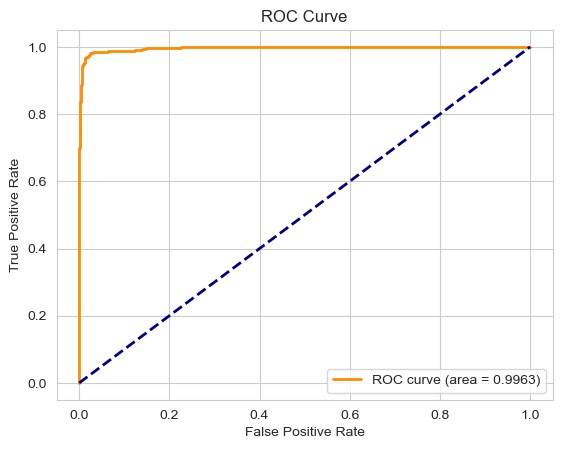

     PN   PP
TN  561    2
TP   44  266


In [37]:
plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.ylim(0, 0.05)
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 2))
plt.plot(epochs, accuracies_epoch, label='accuracy')
plt.plot(epochs, precision_epoch, label='precision')
plt.plot(epochs, sensitivity_epoch, label='sensitivity')
plt.plot(epochs, specificity_epoch, label='specificity')
plt.plot(epochs, f1_epoch, label='f1')
plt.legend()
plt.grid(True)
plt.show()

fpr, tpr, thresholds = roc_curve(pred_summary["label"], pred_summary["score"])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(pd.DataFrame(conf_matrix, index=["TN", "TP"], columns=["PN", "PP"]))

### Test model

In [17]:
model.load_state_dict(torch.load("model_dec12_dev.pt"))

<All keys matched successfully>

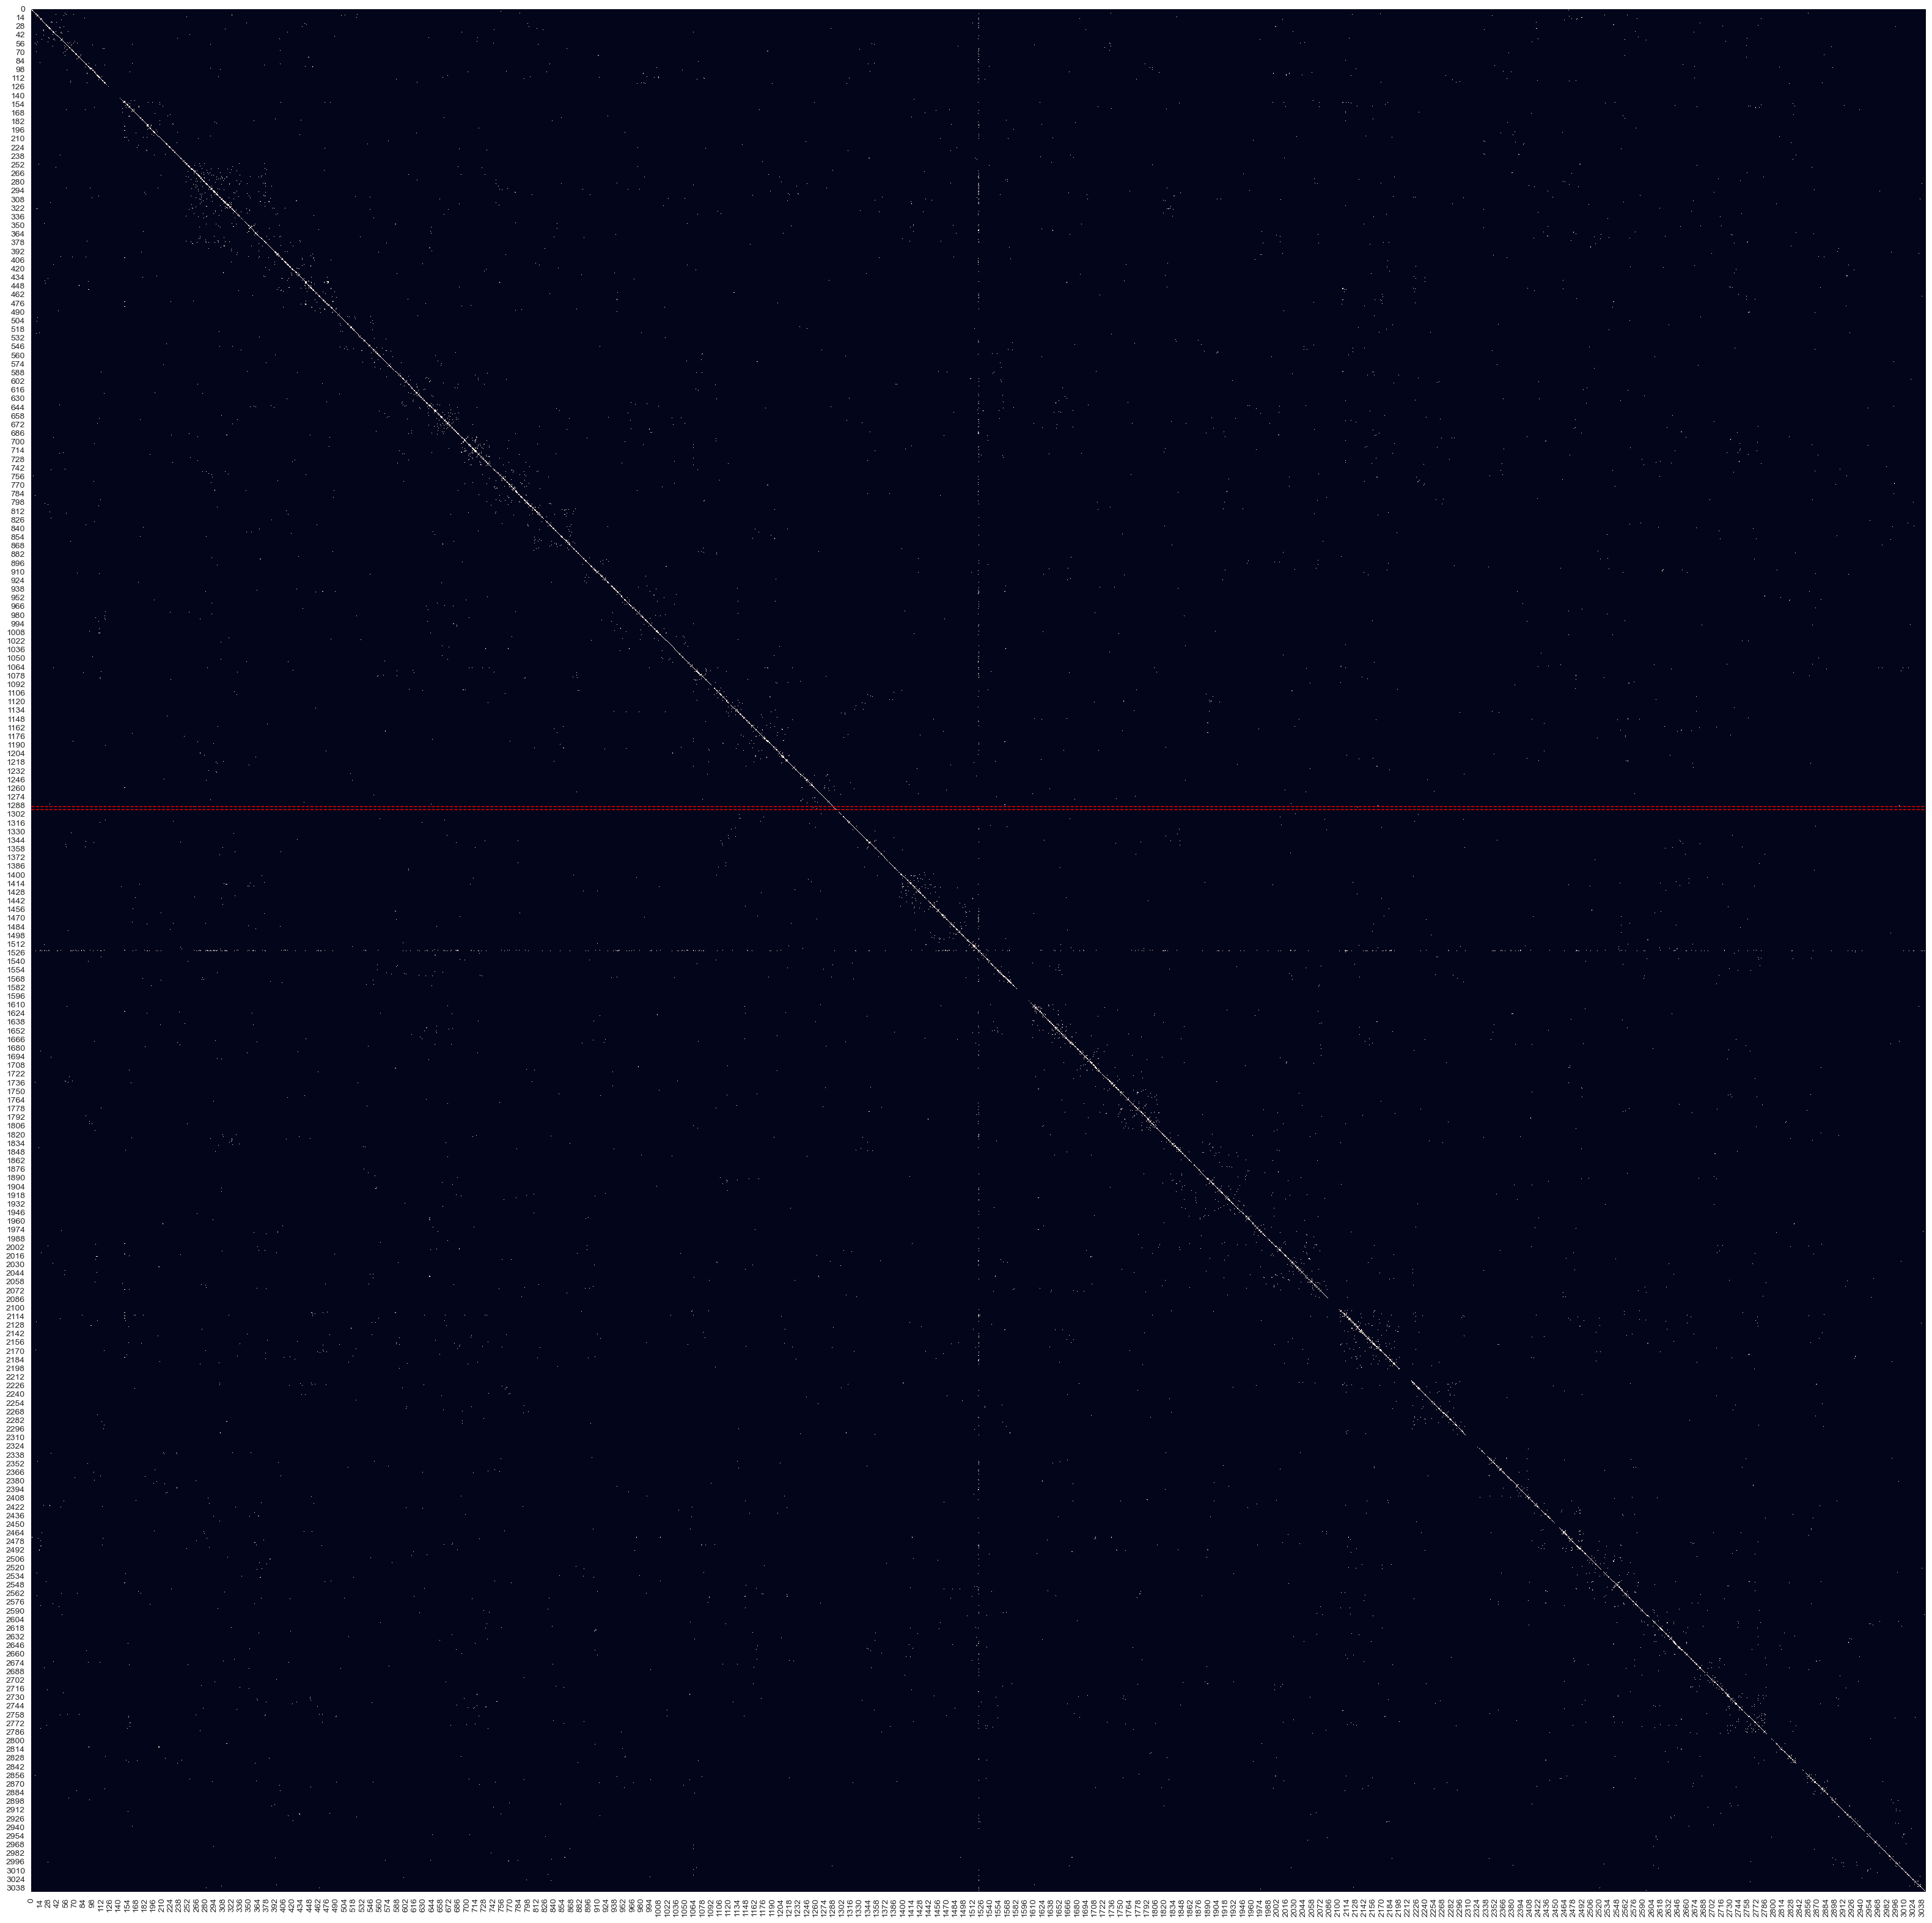

In [18]:
matrix_test = read_mtx("data/raw/LC676/LC676_merged_hg38.sc_AAACTGCGTACGGAGT/matrix.mtx", chr_index)
#LC499/LC499_TTATGTCAGAGGAACA
#LC499/LC499_AACGGGAGTCCCGAGT
#LC675/LC675_AGCGTGCAGAGAGTAG
#LC500/LC500_AAACGAAGTTAGCTCA

plt.figure(figsize=(40, 40))
plot = sns.heatmap(matrix_test > 0, cbar=False)

#plot.axvline(x=np.where(chr_index["loc"] == "chr7_55000000")[0][0], color='red', linestyle='--', linewidth=1)

plot.axhline(y=np.where(chr_index["loc"] == "chr7_53000000")[0][0], color='red', linestyle='--', linewidth=1)
plot.axhline(y=np.where(chr_index["loc"] == "chr7_58000000")[0][0], color='red', linestyle='--', linewidth=1)

plt.show()

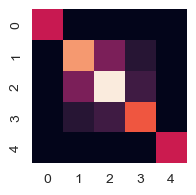

In [19]:
matrix_test = read_mtx("data/raw/LC500/LC500_ACTAGGTGTTACCCAA/matrix.mtx", chr_index)

plt.figure(figsize=(2, 2))
plot = sns.heatmap(np.log2(matrix_test + 1)[1288:1293, 1288:1293], cbar=False)

plt.show()

In [20]:
def slide(matrix, window_0, window_1):
    half_window_0 = int((window_0 - 1) / 2)
    half_window_1 = int((window_1 - 1) / 2)

    centers = []
    tensors = []

    for i in range(matrix.shape[0] - window_1 + 1):
        center = i + half_window_1
        lower = center - half_window_0
        upper = center + half_window_0 + 1

        tensors.append(matrix[lower:upper, :])
        centers.append(center)

    test_tensor = torch.stack(tensors, dim=0)
    centers = np.array(centers)

    return test_tensor, centers

In [21]:
test_tensor, centers = slide(torch.from_numpy(matrix_test), window_0, window_1)

model.eval()
with torch.no_grad():
    test_tensor = test_tensor.unsqueeze(1).float().to("mps")

    test_pred = torch.sigmoid(model(test_tensor, centers)).to("cpu")

test_predictions = pd.DataFrame({"coord": centers, "prediction": test_pred})

test_predictions = pd.merge(test_predictions, chr_index, left_on="coord", right_on="index", how="left").drop("index",
                                                                                                             axis=1)

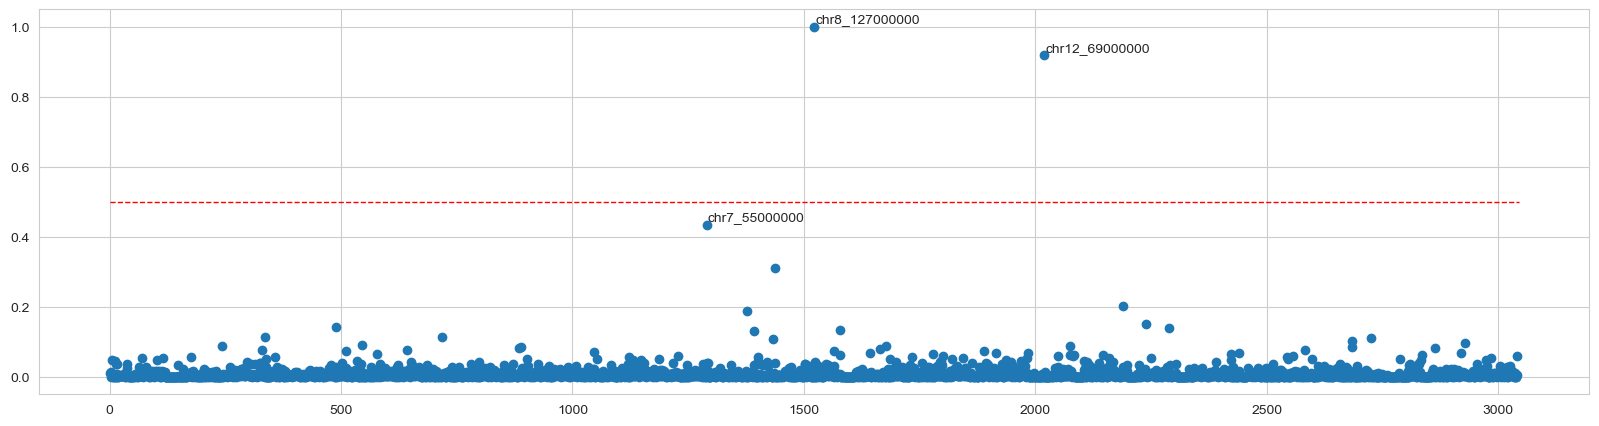

In [22]:
plt.figure(figsize=(20, 5))

plt.scatter(test_predictions['coord'], test_predictions['prediction'])

top_indices = test_predictions['prediction'].argsort()[-3:]

texts = []
for i in top_indices:
    x_value = test_predictions['loc'][i]
    texts.append(plt.text(i, test_predictions['prediction'][i], f'{x_value}', ha='center', va='bottom'))

adjust_text(texts)

plt.hlines(y=0.5, xmin=0, xmax=3044, color='red', linestyle='--', linewidth=1)

plt.ylim(-0.05, 1.05)
plt.show()

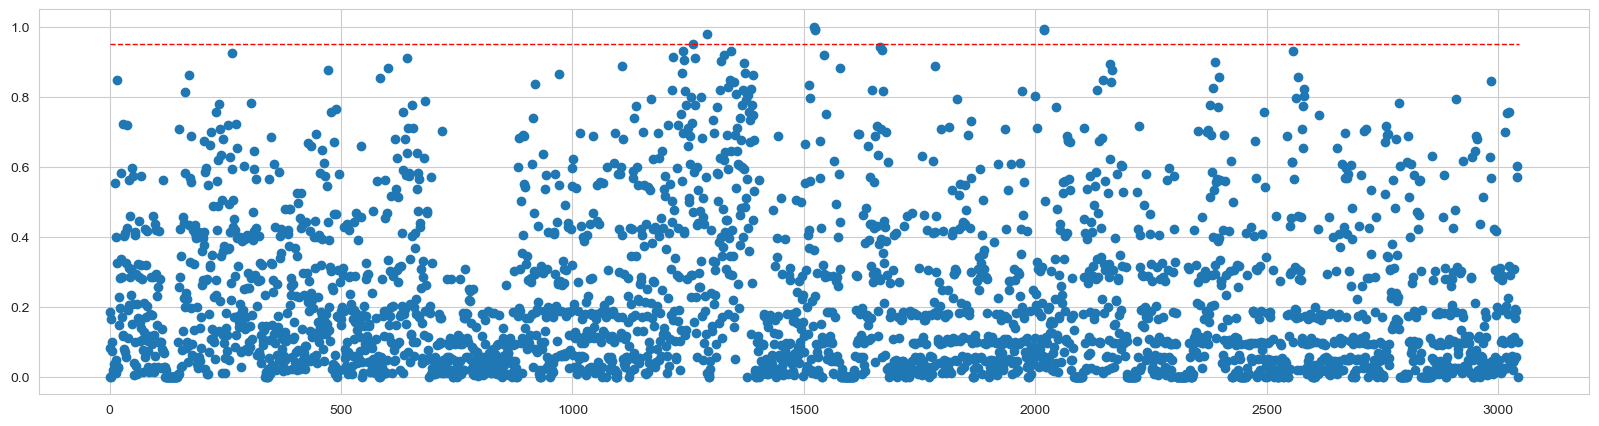

In [23]:
test_predictions = pd.read_table("data/assessment/lm_val_499500_pred.txt", header=0)

plt.figure(figsize=(20, 5))

plt.scatter(test_predictions.index, test_predictions['LC500_ACTAGGTGTTACCCAA'])

plt.hlines(y=0.95, xmin=0, xmax=3044, color='red', linestyle='--', linewidth=1)

plt.ylim(-0.05, 1.05)
plt.show()

In [24]:
#torch.save(model.state_dict(), "model_dec12_dev.pt")

### Summarize datasets

In [ ]:
rm = int((window_0 - 1) / 2)
record = chr_index[rm:-rm]

bcs = os.listdir("data/raw/lm_val_499500")

for b1 in bcs:
    
    path = "data/raw/" + b1[0:5] + "/" + b1
    
    if not os.path.exists(path + "/1000000.CNV.bedGraph"):
        continue
    
    try:
        mat = read_mtx(path + "/matrix.mtx", chr_index)
    except:
        continue
    
    test_tensor, centers = slide(torch.from_numpy(mat), window_0, window_1)

    model.eval()
    with torch.no_grad():
        test_tensor = test_tensor.unsqueeze(1).float().to("mps")

        test_pred = (torch.sigmoid(model(test_tensor, centers)).to("cpu").numpy() > prob_threshold).astype(int)

        record = pd.concat([record, pd.DataFrame({b1: test_pred}, index=range(2, len(test_pred) + 2))], axis=1)

In [ ]:
freq = record.iloc[:, 2:].sum(axis=1) / record.iloc[:, 2:].shape[1]
count = record.iloc[:, 2:].sum(axis=1)
freq = pd.DataFrame({"count": count, "freq": freq})

freq = pd.concat(
    [pd.DataFrame({"count": [0, 0], "freq": [0, 0]}), freq, pd.DataFrame({"count": [0, 0], "freq": [0, 0]})])
freq = freq.reset_index(drop=True)
freq = pd.concat([chr_index, freq], axis=1)

freq[["chr", "start"]] = freq["loc"].str.split("_", expand=True)
freq = freq.drop(["loc", "index"], axis=1)
freq["end"] = freq["start"].astype(int) + 1000000

freq = freq[freq.columns[2:].tolist() + freq.columns[:2].tolist()]

freq.to_csv("target.txt", index=False, sep="\t")

### Comparison with Linear Model

In [26]:
model.load_state_dict(torch.load("model_dec12_dev.pt"))
model.to("mps")

CNN(
  (conv_f2_l1): Conv2d(1, 8, kernel_size=(5, 45), stride=(1, 11), padding=(0, 2))
  (conv_f2_l2): Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4))
  (bn_f2_l1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_f2_l2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc_l1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_f2_l1): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_f2_l2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_l1): Linear(in_features=223, out_features=64, bias=True)
  (fc_l2): Linear(in_features=64, out_features=1, bias=True)
  (dropout_f2): Dropout(p=0.5, inplace=False)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

In [29]:
lm_val_pred_1 = pd.read_csv("data/lm_summarized/prediction_499500.csv", header=None)
lm_val_pred_1.columns = ["cnv", "ratio", "gini", "label", "score"]

#lm_val_pred_1 = pd.read_csv("data/lm_summarized/prediction_all_676677.csv", header=None)
#lm_val_pred_1.columns = ["cnv", "ratio", "gini", "label","score"]

#lm_val_pred_3 = pd.read_csv("data/lm_summarized/prediction_all_mixed.csv", header=None)
#lm_val_pred_3.columns = ["cnv", "ratio", "gini", "label","score"]

In [30]:
sizes = []

val_labels = []
val_predictions = []
val_scores = []
val_directories = []

model.eval()
with torch.no_grad():
    for x2, y0, bcs, coord in test_dataloader1:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")

        yh = model(x2, coord)

        yp = (torch.sigmoid(yh) > prob_threshold).int()

        accu = torch.sum((yp == y0).float()) / len(y0)

        sizes.append(len(y0))

        val_labels = val_labels + y0.int().to("cpu").numpy().tolist()
        val_predictions = val_predictions + yp.to("cpu").numpy().tolist()
        val_scores = val_scores + torch.sigmoid(yh).to("cpu").numpy().tolist()
        val_directories = val_directories + list(bcs)

In [31]:
pred_summary = pd.DataFrame(
    {"label": val_labels, "prediction": val_predictions, "score": val_scores, "barcode": val_directories})
pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
precision = precision_score(pred_summary["label"], pred_summary["prediction"])
recall = recall_score(pred_summary["label"], pred_summary["prediction"])
f1 = f1_score(pred_summary["label"], pred_summary["prediction"])
specificity = tn / (tn + fp)

In [32]:
fpr_lm_1, tpr_lm_1, _ = roc_curve(lm_val_pred_1["label"], lm_val_pred_1["score"])
roc_auc_lm_1 = auc(fpr_lm_1, tpr_lm_1)

#fpr_lm_2, tpr_lm_2, _ = roc_curve(lm_val_pred_2["label"], lm_val_pred_2["score"])
#roc_auc_lm_2 = auc(fpr_lm_2, tpr_lm_2)

#fpr_lm_3, tpr_lm_3, _ = roc_curve(lm_val_pred_3["label"], lm_val_pred_3["score"])
#roc_auc_lm_3 = auc(fpr_lm_3, tpr_lm_3)

fpr_cnn, tpr_cnn, _ = roc_curve(pred_summary["label"], pred_summary["score"])
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

In [41]:
lm_val_pred_1["prediction"] = (lm_val_pred_1["score"] > 0.95).astype(int)

conf_matrix = confusion_matrix(lm_val_pred_1["label"], lm_val_pred_1["prediction"])
tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

accuracy = accuracy_score(lm_val_pred_1["label"], lm_val_pred_1["prediction"])
precision = precision_score(lm_val_pred_1["label"], lm_val_pred_1["prediction"])
recall = recall_score(lm_val_pred_1["label"], lm_val_pred_1["prediction"])
f1 = f1_score(lm_val_pred_1["label"], lm_val_pred_1["prediction"])
specificity = tn / (tn + fp)

In [42]:
accuracy, precision, recall, specificity

(0.8900343642611683,
 0.9692982456140351,
 0.7129032258064516,
 0.9875666074600356)

In [44]:
conf_matrix

array([[556,   7],
       [ 89, 221]])

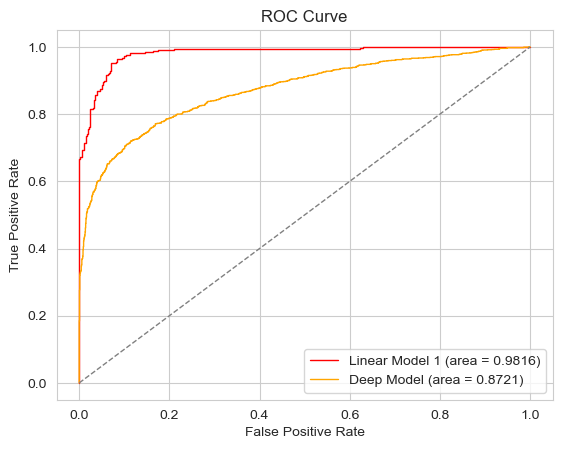

In [33]:
plt.figure()
plt.plot(fpr_lm_1, tpr_lm_1, color='red', lw=1, label='Linear Model 1 (area = {:.4f})'.format(roc_auc_lm_1))
#plt.plot(fpr_lm_2, tpr_lm_2, color='blue', lw=1, label='Linear Model 2 (area = {:.4f})'.format(roc_auc_lm_2))
#plt.plot(fpr_lm_3, tpr_lm_3, color='green', lw=1, label='Linear Model M (area = {:.4f})'.format(roc_auc_lm_3))
plt.plot(fpr_cnn, tpr_cnn, color='orange', lw=1, label='Deep Model (area = {:.4f})'.format(roc_auc_cnn))
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [38]:
pred_summary.iloc[np.where(pred_summary["correct"] == False)[0], :]

,label,prediction,score,barcode,correct
20,1,0,0.207814,LC676_merged_hg38.sc_AAATGAGGTGCCGGTT,False
24,1,0,0.411740,LC676_merged_hg38.sc_AAATGCCCAGTGGTCC,False
238,1,0,0.368492,LC676_merged_hg38.sc_CAACCAATCTGCGTCT,False
243,1,0,0.476360,LC676_merged_hg38.sc_CAACGTACACATAAAG,False
245,1,0,0.469282,LC676_merged_hg38.sc_CAACGTACATTGAACC,False
...,...,...,...,...,...
2956,0,1,0.926595,LC677_merged_hg38.sc_TTTGGCCGTTACTACG,False
2957,0,1,0.993425,LC677_merged_hg38.sc_TTTGGTTAGGCGTAGT,False
2958,0,1,0.913208,LC677_merged_hg38.sc_TTTGGTTCAGCAGGTA,False
2959,0,1,0.613360,LC677_merged_hg38.sc_TTTGTGTCACAGGTAG,False


In [39]:
#pred_summary["barcode"].to_csv("data/processed/barcode_val_499500.txt", index=False, header=False)

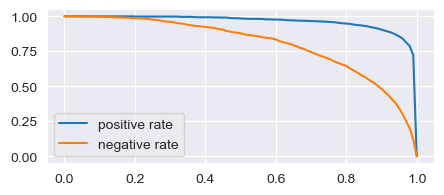

In [40]:
pos_rate_dm = []
neg_rate_dm = []

for threshold in np.arange(0,1.01,0.01):
    pred_summary["prediction"] = (pred_summary["score"] > threshold).astype(int)
    pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]
    
    pos_summary = pred_summary[pred_summary["label"]==1]
    pos_rate = pos_summary['prediction'].sum()/pos_summary.shape[0]
    pos_rate_dm.append(pos_rate)
    
    neg_summary = pred_summary[pred_summary["label"]==0]
    neg_rate = neg_summary['prediction'].sum()/neg_summary.shape[0]
    neg_rate_dm.append(neg_rate)
    
plt.figure(figsize=(5, 2))
plt.plot(np.arange(0,1.01,0.01), pos_rate_dm, label='positive rate')
plt.plot(np.arange(0,1.01,0.01), neg_rate_dm, label='negative rate')
plt.legend()

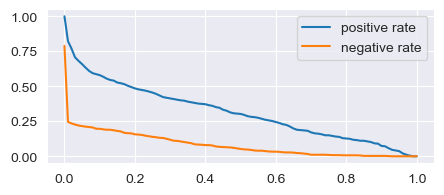

In [41]:
pos_rate_lm = []
neg_rate_lm = []

for threshold in np.arange(0,1.01,0.01):
    lm_val_pred_1["prediction"] = (lm_val_pred_1["score"] > threshold).astype(int)
    lm_val_pred_1["correct"] = lm_val_pred_1["label"] == lm_val_pred_1["prediction"]
    
    pos_summary = lm_val_pred_1[lm_val_pred_1["label"]==1]
    pos_rate = pos_summary['prediction'].sum()/pos_summary.shape[0]
    pos_rate_lm.append(pos_rate)
    
    neg_summary = lm_val_pred_1[lm_val_pred_1["label"]==0]
    neg_rate = neg_summary['prediction'].sum()/neg_summary.shape[0]
    neg_rate_lm.append(neg_rate)
    
plt.figure(figsize=(5, 2))
plt.plot(np.arange(0,1.01,0.01), pos_rate_lm, label='positive rate')
plt.plot(np.arange(0,1.01,0.01), neg_rate_lm, label='negative rate')
plt.legend()

Text(0.01, 0.5762917798137197, '(0.01, 0.58)')

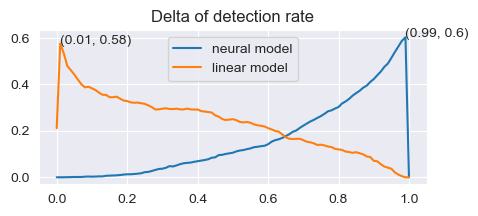

In [42]:
delta_dm = np.asarray(pos_rate_dm) - np.asarray(neg_rate_dm)
delta_lm = np.asarray(pos_rate_lm) - np.asarray(neg_rate_lm)

plt.figure(figsize=(5, 2))
plt.title('Delta of detection rate')
plt.plot(np.arange(0,1.01,0.01), delta_dm, label='neural model')
plt.plot(np.arange(0,1.01,0.01), delta_lm, label='linear model')
plt.legend()

max_index = np.argmax(delta_dm)
max_x = np.arange(0,1.01,0.01)[max_index]
max_y = delta_dm[max_index]

plt.annotate(f'{np.round(max_x,2),np.round(max_y,2)}', 
             xy=(max_x, max_y), 
             xytext=(max_x, max_y))

max_index = np.argmax(delta_lm)
max_x = np.arange(0,1.01,0.01)[max_index]
max_y = delta_lm[max_index]

plt.annotate(f'{np.round(max_x,2),np.round(max_y,2)}', 
             xy=(max_x, max_y), 
             xytext=(max_x, max_y))

### Generalize to other datasets

In [31]:
#model.load_state_dict(torch.load("model_nov29.pt"))
#model.to("mps")

In [35]:
lm_test_pred_1 = pd.read_csv("data/lm_summarized/prediction_676677.csv", header=None)
lm_test_pred_1.columns = ["cnv", "ratio", "gini", "label", "score"]

#lm_test_pred_2 = pd.read_csv("data/lm_summarized/prediction_729730_676677.csv", header=None)
#lm_test_pred_2.columns = ["cnv", "ratio", "gini", "label","score"]

#lm_test_pred_3 = pd.read_csv("data/lm_summarized/prediction_729730_mixed.csv", header=None)
#lm_test_pred_3.columns = ["cnv", "ratio", "gini", "label","score"]

In [36]:
sizes = []

val_labels = []
val_predictions = []
val_scores = []
val_directories = []

model.eval()
with torch.no_grad():
    for x2, y0, bcs, coord in test_dataloader1:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")

        yh = model(x2, coord)

        yp = (torch.sigmoid(yh) > prob_threshold).int()

        accu = torch.sum((yp == y0).float()) / len(y0)

        sizes.append(len(y0))

        val_labels = val_labels + y0.int().to("cpu").numpy().tolist()
        val_predictions = val_predictions + yp.to("cpu").numpy().tolist()
        val_scores = val_scores + torch.sigmoid(yh).to("cpu").numpy().tolist()
        val_directories = val_directories + list(bcs)

In [37]:
pred_summary = pd.DataFrame(
    {"label": val_labels, "prediction": val_predictions, "score": val_scores, "barcode": val_directories})
pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
precision = precision_score(pred_summary["label"], pred_summary["prediction"])
recall = recall_score(pred_summary["label"], pred_summary["prediction"])
f1 = f1_score(pred_summary["label"], pred_summary["prediction"])
specificity = tn / (tn + fp)

In [38]:
fpr_lm_1, tpr_lm_1, _ = roc_curve(lm_test_pred_1["label"], lm_test_pred_1["score"])
roc_auc_lm_1 = auc(fpr_lm_1, tpr_lm_1)

#fpr_lm_2, tpr_lm_2, _ = roc_curve(lm_test_pred_2["label"], lm_test_pred_2["score"])
#roc_auc_lm_2 = auc(fpr_lm_2, tpr_lm_2)

#fpr_lm_3, tpr_lm_3, _ = roc_curve(lm_test_pred_3["label"], lm_test_pred_3["score"])
#roc_auc_lm_3 = auc(fpr_lm_3, tpr_lm_3)

fpr_cnn, tpr_cnn, _ = roc_curve(pred_summary["label"], pred_summary["score"])
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

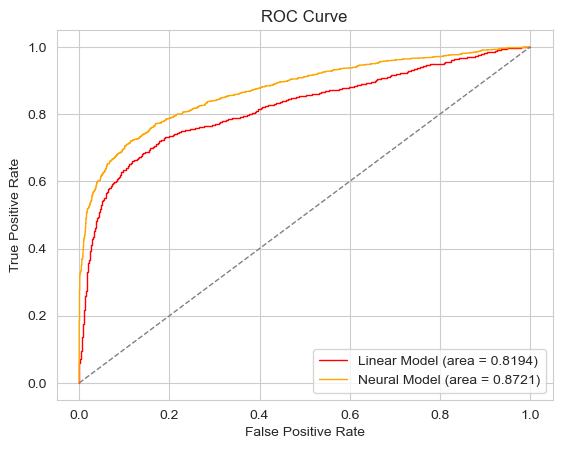

In [41]:
plt.figure()
plt.plot(fpr_lm_1, tpr_lm_1, color='red', lw=1, label='Linear Model (area = {:.4f})'.format(roc_auc_lm_1))
#plt.plot(fpr_lm_2, tpr_lm_2, color='blue', lw=1, label='Linear Model 2 (area = {:.4f})'.format(roc_auc_lm_2))
#plt.plot(fpr_lm_3, tpr_lm_3, color='green', lw=1, label='Linear Model M (area = {:.4f})'.format(roc_auc_lm_3))
plt.plot(fpr_cnn, tpr_cnn, color='orange', lw=1, label='Neural Model (area = {:.4f})'.format(roc_auc_cnn))
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Model Dissection

In [40]:
model.load_state_dict(torch.load("model_dec12_dev.pt"))
model.to("mps")
model.eval()

CNN(
  (conv_f2_l1): Conv2d(1, 8, kernel_size=(5, 45), stride=(1, 11), padding=(0, 2))
  (conv_f2_l2): Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4))
  (bn_f2_l1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_f2_l2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc_l1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_f2_l1): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_f2_l2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_l1): Linear(in_features=223, out_features=64, bias=True)
  (fc_l2): Linear(in_features=64, out_features=1, bias=True)
  (dropout_f2): Dropout(p=0.5, inplace=False)
  (dropout_fc): Dropout(p=0.5, inplace=False)
)

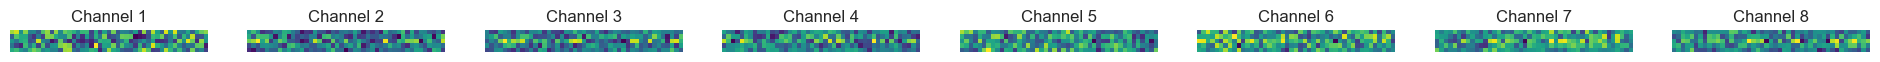

<Axes: >

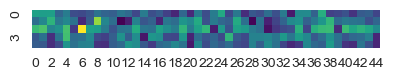

In [174]:
target_layer = model.conv_f2_l1

conv_weights = target_layer.weight.data.cpu().numpy()

num_channels = conv_weights.shape[0]
fig, axes = plt.subplots(1, num_channels, figsize=(num_channels * 3, 3))

for i in range(num_channels):
    kernel_channel = conv_weights[i, 0, :, :]  # Assuming 2D kernel
    axes[i].imshow(kernel_channel, cmap='viridis', interpolation='none')
    axes[i].set_title(f'Channel {i + 1}')
    axes[i].axis('off')

plt.show()

plt.figure(figsize=(4.5, 0.5))
sns.heatmap(np.squeeze(np.mean(conv_weights,axis=0)), cmap='viridis', cbar=False)